In [5]:
import torch
from torch import optim
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence
from utils import FKL, RKL, plot_distribs
from utils import GaussianParticle, GaussianMixture

## 1. Fitting simple Gaussians

We start by defining a simple gaussian target:

In [3]:
# Non trainable Gaussian particle, target of the model.
target = GaussianParticle(
    loc=torch.tensor([3,3], dtype=torch.float),
    scale_tril=0.3*torch.eye(2),
    trainable=False
)

### 1.1 RKL

In [10]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.01)

for step in range(2000):
    loss = kl_divergence(p=target.mvn, q=model.mvn)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%200==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

step:0, loss:8.985939025878906
step:200, loss:2.469557762145996
step:400, loss:1.458482027053833
step:600, loss:0.6209438443183899
step:800, loss:0.0
step:1000, loss:-1.1920928955078125e-07
step:1200, loss:-1.1920928955078125e-07
step:1400, loss:-1.1920928955078125e-07
step:1600, loss:-1.1920928955078125e-07
step:1800, loss:-1.1920928955078125e-07


Visualizing the distributions after optimization:

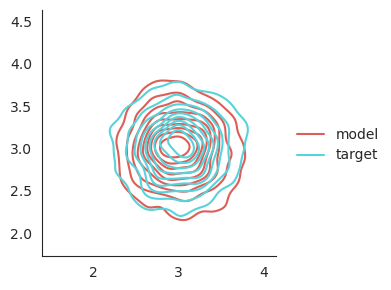

In [11]:
plot_distribs({'model':model, 'target':target})

### 1.2 FKL

The main difference is that we need to initialize our model, we choose a centered and diffuse Gaussian distribution.

In [13]:
# Initializing a Gaussian mixture model with a non-trainable diffuse gaussian distributions:
init= GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=2*torch.eye(2),
    trainable=False
)
model = GaussianMixture(init)

# Trainable Gaussian particle with random initialization.
particle = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# Optimization procedure:
opt = optim.Adam(particle.parameters(), lr=0.01)

for step in range(2000):
    loss = FKL(
        f=particle,
        q=model,
        p=target
    )
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%200==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

# Adding the new particle to the model:
model.add_particle(particle)

step:0, loss:5.634288787841797
step:200, loss:1.6319167613983154
step:400, loss:0.09860114753246307
step:600, loss:0.032480258494615555
step:800, loss:0.1350155770778656
step:1000, loss:0.058463361114263535
step:1200, loss:-0.03417259827256203
step:1400, loss:0.0065536051988601685
step:1600, loss:0.0037253927439451218
step:1800, loss:0.014394763857126236


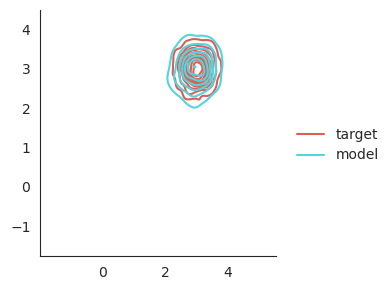

In [14]:
plot_distribs({'target':target, 'model':model})

## 2. Fitting a multimodal target

Defining the target:

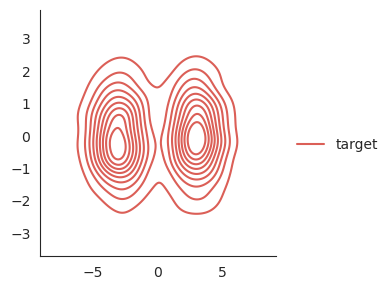

In [15]:
# Non trainable gaussian mixture:
particle1 = GaussianParticle(
    loc=torch.tensor([3,0], dtype=torch.float),
    scale_tril=torch.eye(2),
    trainable=False
)
particle2 = GaussianParticle(
    loc=torch.tensor([-3,0], dtype=torch.float),
    scale_tril=torch.eye(2),
    trainable=False
)
target = GaussianMixture(particle1)
target.add_particle(particle2)

plot_distribs({'target':target}, nsamples=2000)

### 2.1 RKL

In [28]:
# Trainable Gaussian particle with random initialization.
model = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)
#model.scale_tril.requires_grad = False

# optimization procedure:
opt = optim.Adam(model.parameters(), lr=0.001)

for step in range(2000):
    # We don't have acces to closed form KL, we use a MCMC estimation of the KL with reparametrization trick:
    loss = RKL(p=target, q=model)
    
    # if loss <0:
    #     break

    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%200==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

step:0, loss:2.6600236892700195
step:200, loss:2.0222063064575195
step:400, loss:1.4844578504562378
step:600, loss:0.32816872000694275
step:800, loss:nan
step:1000, loss:nan
step:1200, loss:nan
step:1400, loss:nan
step:1600, loss:nan
step:1800, loss:nan


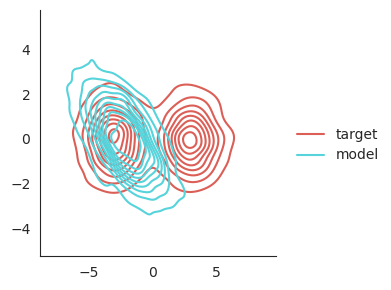

In [29]:
plot_distribs({'target':target, 'model':model}, nsamples=2000)

### 2.2 FKL

In [33]:
# Initializing a Gaussian mixture model with a non-trainable diffuse gaussian distributions:
init= GaussianParticle(
    loc=torch.zeros(2),
    scale_tril=2*torch.eye(2),
    trainable=False
)
model = GaussianMixture(init)

# Trainable Gaussian particle with random initialization.
particle = GaussianParticle(
    loc=torch.randn(2),
    scale_tril=torch.eye(2),
    trainable=True
)

# Optimization procedure:
opt = optim.Adam(particle.parameters(), lr=0.01)

for step in range(2000):
    loss = FKL(
        f=particle,
        q=model,
        p=target
    )
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    # logging:
    if step%200==0:
        print(f'step:{step}, loss:{loss.detach().numpy()}')

# Adding the new particle to the model:
model.add_particle(particle)

step:0, loss:1.496720552444458
step:200, loss:0.786540150642395
step:400, loss:0.5091020464897156
step:600, loss:0.503578782081604
step:800, loss:0.5138596892356873
step:1000, loss:0.42967933416366577
step:1200, loss:0.4579050540924072
step:1400, loss:0.4932643473148346
step:1600, loss:0.4466581344604492
step:1800, loss:0.4808931052684784


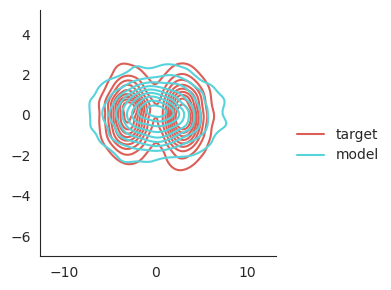

In [34]:
plot_distribs({'target':target, 'model':model}, nsamples=2000)

## 3. Fitting a boosting model on a complex distribution

We initialize a model with a centered diffuse gaussian:

In [62]:
init = GaussianParticle(
    loc=torch.tensor([0,0], dtype=torch.float),
    covariance_matrix=2*torch.eye(2),
    requires_grad=False
)
gm_model = GaussianMixture(init)

In [63]:
### LET US NOW TRY TO FIT A GM ON THE TARGET ###
K = 2

for i in range(K):
    new_particle = GaussianParticle(
        loc=torch.randn(2),
        covariance_matrix=torch.eye(2),
        requires_grad=True
    )

    opt = optim.Adam(new_particle.parameters(), lr=0.001)

    losses = []
    for step in range(5000):
        loss = FKLLoss(
            f=new_particle,
            q=gm_model,
            p=gm_target,
            nsamples=2000
        )
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        # logging:
        losses.append(loss.detach().numpy())
        if step%300==0:
            print(f'step:{step}, loss:{loss.detach().numpy()}')
    
    for param in new_particle.parameters():
        param.requires_grad = False

    gm_model.add_particle(new_particle)

step:0, loss:0.44570279121398926
step:300, loss:0.38854506611824036
step:600, loss:0.4054751992225647
step:900, loss:0.3869050145149231
step:1200, loss:0.39865875244140625
step:1500, loss:0.34448710083961487
step:1800, loss:0.3607977032661438
step:2100, loss:0.39003801345825195
step:2400, loss:0.3763396739959717
step:2700, loss:0.37425392866134644
step:3000, loss:0.36620041728019714
step:3300, loss:0.33659201860427856
step:3600, loss:0.3627997636795044
step:3900, loss:0.3642769753932953
step:4200, loss:0.34900787472724915
step:4500, loss:0.33994972705841064
step:4800, loss:0.34943509101867676
step:0, loss:0.6833874583244324
step:300, loss:0.4062383770942688
step:600, loss:0.3294217586517334
step:900, loss:0.25573045015335083
step:1200, loss:0.2235669195652008
step:1500, loss:0.1693698912858963
step:1800, loss:0.17253035306930542
step:2100, loss:0.14379137754440308
step:2400, loss:0.1293383687734604
step:2700, loss:0.13250237703323364
step:3000, loss:0.14102375507354736
step:3300, loss:

In [64]:
gm_model.weights

tensor([0.5037, 0.1753, 0.3210])

In [67]:
gm_model.particles[1].loc

Parameter containing:
tensor([-2.2649, -0.0095])

In [68]:
gm_model.particles[2].loc

Parameter containing:
tensor([2.1940, 0.0054])

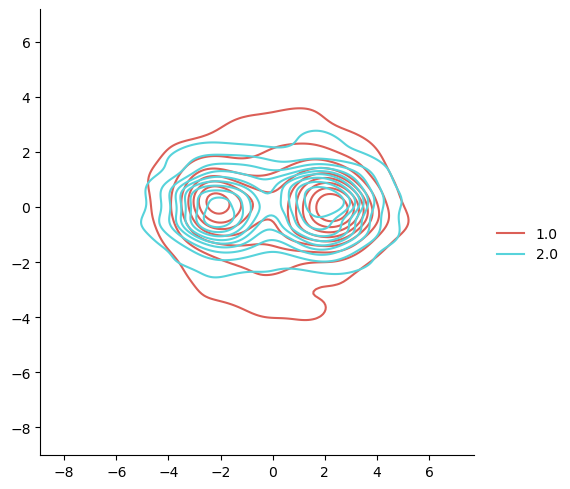

In [65]:
plot_distribs([gm_model, gm_target])

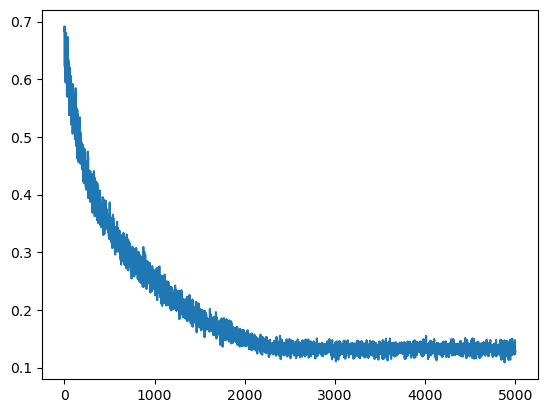

In [66]:
plt.plot(losses)
plt.show()